### In this part, we would like to see how our customers behave towards our product, so cconducting cohort analysis can help us understand if the customer is retained on the platform and is using our products frequently.

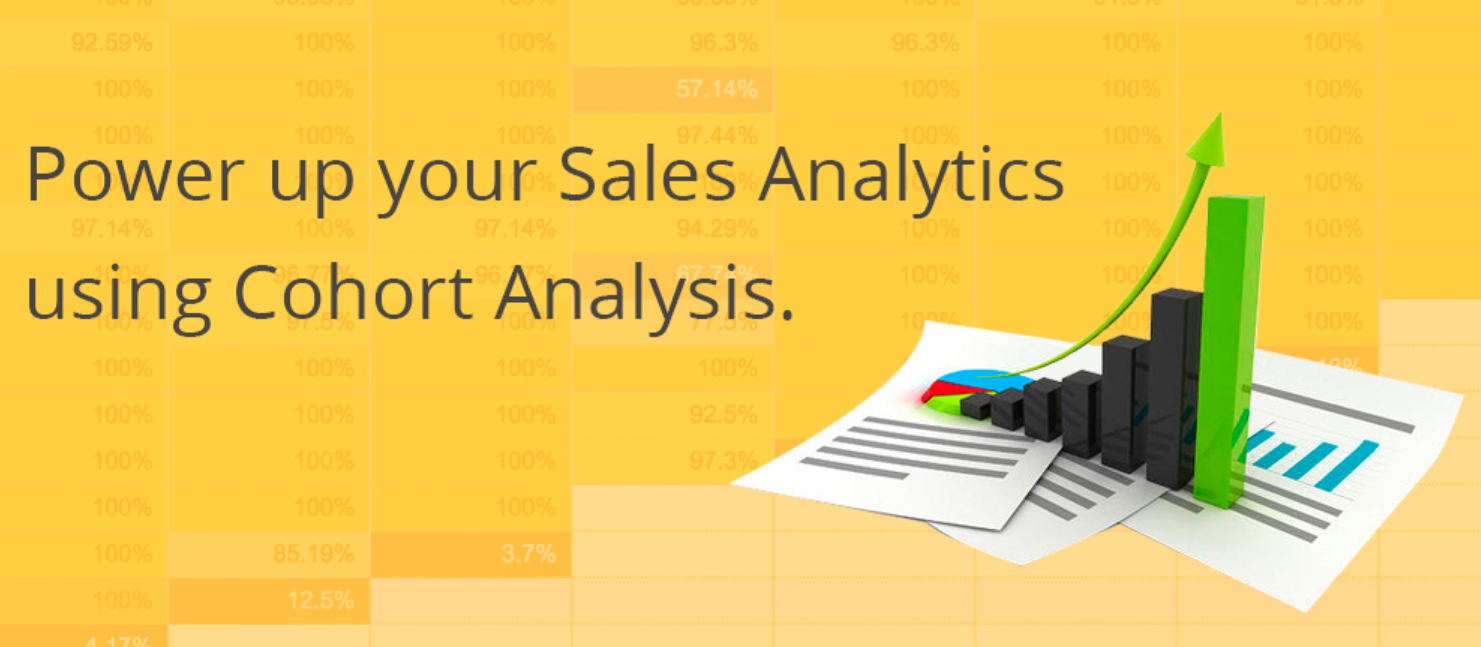

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

# importing all custom functions
from Data_Transformation import to_int

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
# loading the dataset
df = pd.read_excel("Online Retail.xlsx")
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
# Checking the missing values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

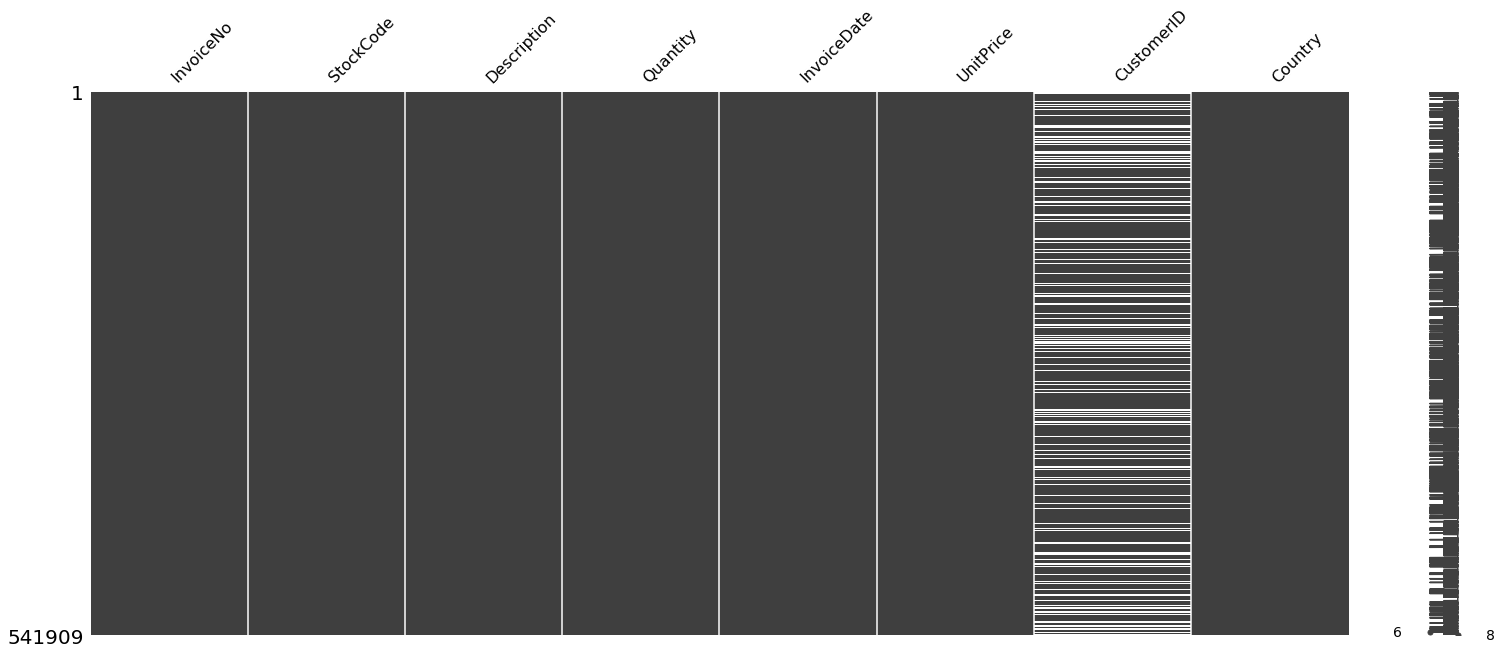

In [5]:
# Visualizing the Missing values
msno.matrix(df)

In [6]:
# Creating a new dataframe with no null values
df1 = df.dropna(subset=['CustomerID'])
df1.shape

(406829, 8)

In [7]:
# checking the datatype
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
# Converting Customer ID from float to int using a custom function to_int()
from Data_Transformation import to_int
df1['CustomerID'] = df1['CustomerID'].apply(to_int)

### Creating Cohort

#### Creating Cohort Month

In [9]:
# Data Munging for creating two columns - invoice month and cohort month

# Defining a function to convert date to month and year
def to_month(date):
    return dt.datetime(date.year, date.month, 1)

df1['InvoiceMonth'] = df1['InvoiceDate'].apply(to_month)
df1['CohortMonth'] = df1.groupby('CustomerID')['InvoiceMonth'].transform('min')

#### Creating Cohort Index

In [10]:
# defining a function to get year, month and day from date so as to find the difference between incoice and cohort month
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date(df1, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date(df1, 'CohortMonth')
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
df1['CohortIndex'] = year_diff * 12 + month_diff + 1

In [11]:
df1.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceMonth  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom   2010-12-01   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom   2010-12-01   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   

  CohortMonth  CohortIndex  
0  2010-12-01            1  
1  2010-12-01            1  
2  2010-12-01            1  
3  2010-12-01            1  
4  2010-12-01            1

### Creating Cohort 1 based on # Customers and Retention Rate

In [12]:
cohort_data = df1.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_count = cohort_data.pivot_table(index = 'CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')

cohort_count

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   948.0  362.0  317.0  367.0  341.0  376.0  360.0  336.0  336.0   
2011-01-01   421.0  101.0  119.0  102.0  138.0  126.0  110.0  108.0  131.0   
2011-02-01   380.0   94.0   73.0  106.0  102.0   94.0   97.0  107.0   98.0   
2011-03-01   440.0   84.0  112.0   96.0  102.0   78.0  116.0  105.0  127.0   
2011-04-01   299.0   68.0   66.0   63.0   62.0   71.0   69.0   78.0   25.0   
2011-05-01   279.0   66.0   48.0   48.0   60.0   68.0   74.0   29.0    NaN   
2011-06-01   235.0   49.0   44.0   64.0   58.0   79.0   24.0    NaN    NaN   
2011-07-01   191.0   40.0   39.0   44.0   52.0   22.0    NaN    NaN    NaN   
2011-08-01   167.0   42.0   42.0   42.0   23.0    NaN    NaN    NaN    NaN   
2011-09-01   298.0   89.0   97.0   36.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   352.0   93.0   46.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   321.0   43.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13  
CohortMonth                              
2010-12-01   374.0  354.0  474.0  260.0  
2011-01-01   146.0  155.0   63.0    NaN  
2011-02-01   119.0   35.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

#### Let us now try to convert these numbers to percentage to get a better idea of the Retention Rate

In [13]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size, axis = 0)
retention.round(3) * 100

CohortIndex     1     2     3     4     5     6     7     8     9     10  \
CohortMonth                                                                
2010-12-01   100.0  38.2  33.4  38.7  36.0  39.7  38.0  35.4  35.4  39.5   
2011-01-01   100.0  24.0  28.3  24.2  32.8  29.9  26.1  25.7  31.1  34.7   
2011-02-01   100.0  24.7  19.2  27.9  26.8  24.7  25.5  28.2  25.8  31.3   
2011-03-01   100.0  19.1  25.5  21.8  23.2  17.7  26.4  23.9  28.9   8.9   
2011-04-01   100.0  22.7  22.1  21.1  20.7  23.7  23.1  26.1   8.4   NaN   
2011-05-01   100.0  23.7  17.2  17.2  21.5  24.4  26.5  10.4   NaN   NaN   
2011-06-01   100.0  20.9  18.7  27.2  24.7  33.6  10.2   NaN   NaN   NaN   
2011-07-01   100.0  20.9  20.4  23.0  27.2  11.5   NaN   NaN   NaN   NaN   
2011-08-01   100.0  25.1  25.1  25.1  13.8   NaN   NaN   NaN   NaN   NaN   
2011-09-01   100.0  29.9  32.6  12.1   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10-01   100.0  26.4  13.1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-11-01   100.0  13.4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-12-01   100.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex    11    12    13  
CohortMonth                    
2010-12-01   37.3  50.0  27.4  
2011-01-01   36.8  15.0   NaN  
2011-02-01    9.2   NaN   NaN  
2011-03-01    NaN   NaN   NaN  
2011-04-01    NaN   NaN   NaN  
2011-05-01    NaN   NaN   NaN  
2011-06-01    NaN   NaN   NaN  
2011-07-01    NaN   NaN   NaN  
2011-08-01    NaN   NaN   NaN  
2011-09-01    NaN   NaN   NaN  
2011-10-01    NaN   NaN   NaN  
2011-11-01    NaN   NaN   NaN  
2011-12-01    NaN   NaN   NaN

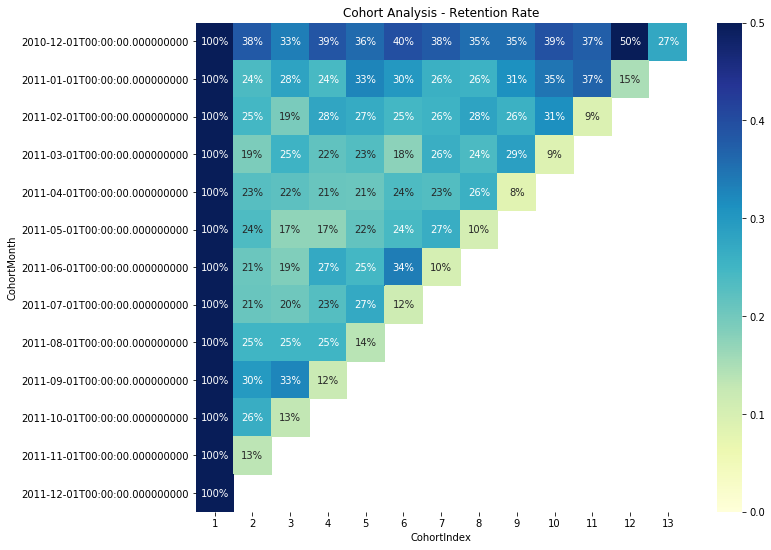

In [14]:
# Visualizing the Retention Rate
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Retention Rate')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

From the above cohort analysis chart, we can see that, for the cohort of 2010 December, about 50% of customers return to our business on 2011 November. This can help the Product Analysts or Marketing Analysts to figure out what campaigns or features were launched at that time which led to higher retention.

### Creating Cohort 2 based on Average Volume Sold

In [15]:
cohort_data2 = df1.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()

average_quantity = cohort_data2.pivot_table(index = 'CohortMonth',
                                            columns = 'CohortIndex',
                                            values = 'Quantity').round(1)
average_quantity

CohortIndex    1     2     3     4     5     6     7     8     9     10    11  \
CohortMonth                                                                     
2010-12-01   11.0  14.6  15.0  14.8  12.9  14.3  15.2  14.8  16.7  16.7  17.3   
2011-01-01   10.0  12.6  12.3  10.9  12.2  14.9  14.2  14.4  11.4   9.9   9.1   
2011-02-01   10.8  12.1  18.6  12.0  11.1  11.4  13.3  12.4  10.3  11.9  12.6   
2011-03-01    9.8   9.9  12.2   9.5  13.6  12.3  13.2  12.2  10.5   8.9   NaN   
2011-04-01    9.8  10.1   9.4  11.6  11.5   8.2   9.7   9.3   7.3   NaN   NaN   
2011-05-01   10.9   9.0  13.9  11.8  10.9   8.7  10.1   7.4   NaN   NaN   NaN   
2011-06-01   10.3  13.7  10.5  13.3  10.2   9.8   9.3   NaN   NaN   NaN   NaN   
2011-07-01    9.7  12.7   7.1   7.8   6.0   7.0   NaN   NaN   NaN   NaN   NaN   
2011-08-01    9.9   6.0   5.3   6.0   7.0   NaN   NaN   NaN   NaN   NaN   NaN   
2011-09-01   11.9   5.5   7.6   8.8   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10-01    8.4   6.9   8.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-11-01    8.7   9.3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-12-01   14.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex    12    13  
CohortMonth              
2010-12-01   12.8  14.8  
2011-01-01    9.5   NaN  
2011-02-01    NaN   NaN  
2011-03-01    NaN   NaN  
2011-04-01    NaN   NaN  
2011-05-01    NaN   NaN  
2011-06-01    NaN   NaN  
2011-07-01    NaN   NaN  
2011-08-01    NaN   NaN  
2011-09-01    NaN   NaN  
2011-10-01    NaN   NaN  
2011-11-01    NaN   NaN  
2011-12-01    NaN   NaN

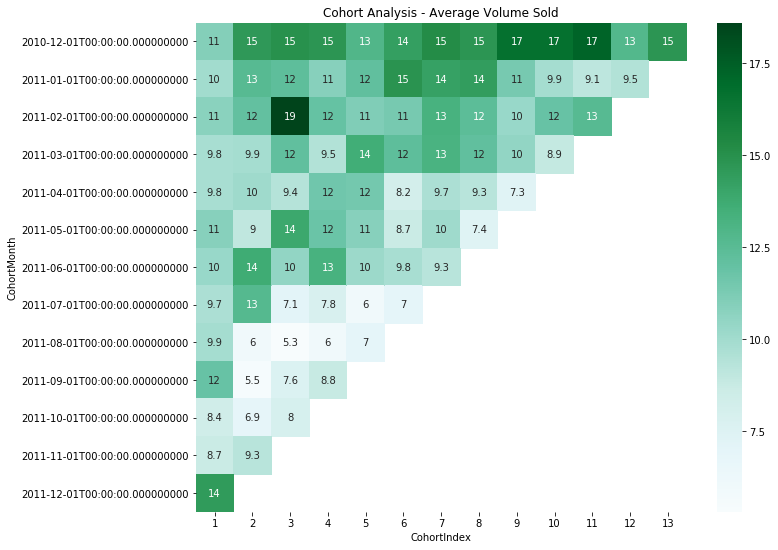

In [16]:
# Visualizing the average volume sold
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Volume Sold')
sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
plt.show()

We can see an overall decline in the average volume of products sold througout the recent cohorts which can be an alarming situation for the Ecommerce company and needs further investigation.

### Creating Cohort 3 based on Average Sales

In [17]:
# Computing Average Sales as a product of Quantity and Unit Price
df1['Sales'] = df1['Quantity']  * df1['UnitPrice']

cohort_data3 = df1.groupby(['CohortMonth', 'CohortIndex'])['Sales'].mean().reset_index()

average_sales = cohort_data3.pivot_table(index = 'CohortMonth',
                                         columns = 'CohortIndex',
                                         values = 'Sales').round(1)

average_sales

CohortIndex    1     2     3     4     5     6     7     8     9     10    11  \
CohortMonth                                                                     
2010-12-01   20.7  25.0  25.1  25.0  19.9  25.5  26.5  25.4  26.0  31.1  30.6   
2011-01-01   18.4  23.5  20.3  17.5  21.5  25.4  24.4  24.5  18.7  20.1  18.7   
2011-02-01   17.0  17.0  19.3  18.8  16.1  15.1  21.6  20.9  17.5  20.6  21.5   
2011-03-01   17.0  17.9  21.5  17.0  19.2  18.1  21.7  17.3  15.4  11.4   NaN   
2011-04-01   16.4  20.2  18.8  18.4  18.6  14.2  14.6  15.3  11.8   NaN   NaN   
2011-05-01   19.0  15.7  21.2  19.4  17.8  14.1  16.1  13.3   NaN   NaN   NaN   
2011-06-01   16.4  14.5  19.0  19.8  15.0  15.9  12.7   NaN   NaN   NaN   NaN   
2011-07-01   13.1  21.2  11.4  12.4  10.5  11.4   NaN   NaN   NaN   NaN   NaN   
2011-08-01   16.1  11.9  11.5  14.4  15.6   NaN   NaN   NaN   NaN   NaN   NaN   
2011-09-01   18.4  10.4  13.2  14.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10-01   13.0  10.8  13.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-11-01   11.9  12.9   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-12-01   26.9   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex    12    13  
CohortMonth              
2010-12-01   22.2  24.7  
2011-01-01   18.4   NaN  
2011-02-01    NaN   NaN  
2011-03-01    NaN   NaN  
2011-04-01    NaN   NaN  
2011-05-01    NaN   NaN  
2011-06-01    NaN   NaN  
2011-07-01    NaN   NaN  
2011-08-01    NaN   NaN  
2011-09-01    NaN   NaN  
2011-10-01    NaN   NaN  
2011-11-01    NaN   NaN  
2011-12-01    NaN   NaN

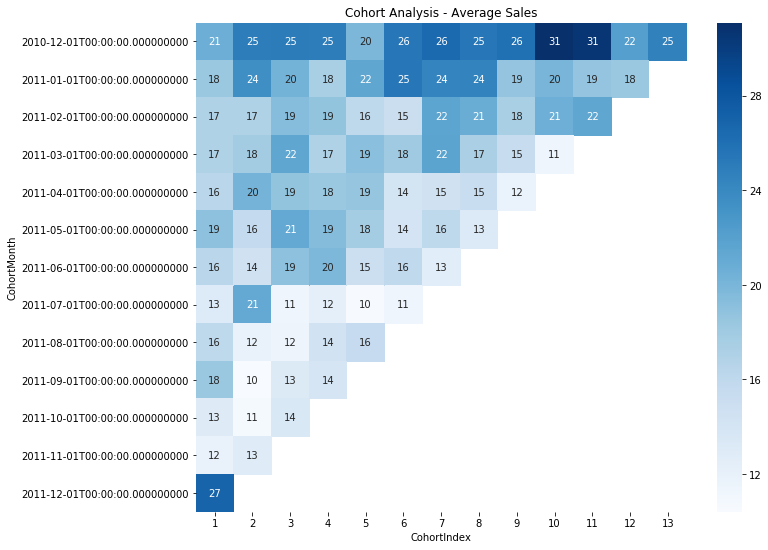

In [18]:
# Visualizing the Average Sales Cohort
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
sns.heatmap(data = average_sales, 
            annot = True, 
            cmap = "Blues")
plt.show()

Here, we can observe the same downward trend of Average Sales as seen in the Cohort Analysis of Average Volume Sold and thus, it would be stressful for marketing and product team to figure out reason for Customer's such a buying behavior.

In [19]:
cohort_data.to_csv("retention_cohort.csv")